In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'colorectal_histology',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.MDH262_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [5]:
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

train_ds = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


In [6]:
base_model = DenseNet121(include_top=False, weights=None, input_shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
attention = layers.Dense(512, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(attention)
model = models.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
history = model.fit(train_ds, validation_data=test_ds, epochs=3)


Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 202s 278ms/step - accuracy: 0.1280 - loss: -2754.1042 - val_accuracy: 0.1270 - val_loss: -1597323.8750
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1253 - loss: -54993.6133 - val_accuracy: 0.1270 - val_loss: -232478.5312
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1253 - loss: -259950.7188 - val_accuracy: 0.1270 - val_loss: -6021090.0000


In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def get_last_conv_layer_name(model):
    # Walk from the end and pick the last Conv2D-like layer
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    raise ValueError("No Conv2D-like layer found in the model.")

def grad_cam(image_bchw, model, last_conv_layer_name=None, class_index=None, eps=1e-8):
    """
    image_bchw: a 4D tensor/array (1, H, W, 3) scaled to [0,1] or [0,255]/255.
    Returns: heatmap as float32 in [0,1] with shape (H, W).
    """
    if not isinstance(image_bchw, tf.Tensor):
        image_bchw = tf.convert_to_tensor(image_bchw, dtype=tf.float32)

    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer_name(model)

    conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_bchw, training=False)
        # Handle binary vs multi-class
        if predictions.shape[-1] == 1:
            # Binary: use the single logit/probability
            target = predictions[:, 0]
        else:
            # Multi-class: pick the requested index or argmax
            if class_index is None:
                class_index = tf.argmax(predictions[0])
            target = predictions[:, class_index]

    grads = tape.gradient(target, conv_outputs)                        # (1, h, w, c)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))               # (c,)
    conv_outputs = conv_outputs[0]                                     # (h, w, c)

    # Weighted combination
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    # ReLU + normalization to [0,1]
    heatmap = tf.maximum(heatmap, 0)
    denom = tf.reduce_max(heatmap) + eps
    heatmap = heatmap / denom

    # Resize to input spatial size
    H, W = image_bchw.shape[1], image_bchw.shape[2]
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (H, W))[:, :, 0]
    return heatmap.numpy(), predictions.numpy(), last_conv_layer_name


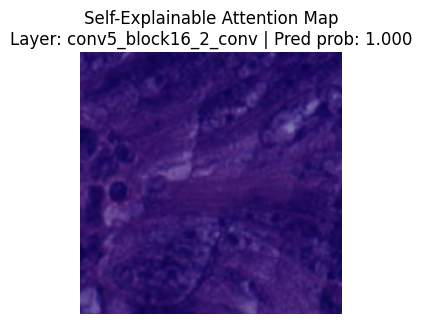

In [11]:
# Take one batch from the test set
for batch_images, batch_labels in test_ds.take(1):
    # Ensure a single image (1, H, W, 3)
    img = tf.expand_dims(batch_images[0], axis=0)

    # Compute Grad-CAM
    heatmap, preds, used_layer = grad_cam(img, model)

    # Optional: get predicted class for display (works for binary or multi-class)
    if preds.shape[-1] == 1:
        pred_text = f"Pred prob: {float(preds[0,0]):.3f}"
    else:
        pred_cls = int(np.argmax(preds[0]))
        pred_text = f"Pred class: {pred_cls} | max prob: {float(np.max(preds[0])):.3f}"

    # Overlay
    plt.figure(figsize=(3.4,3.4))
    plt.imshow(batch_images[0])                    # original image
    plt.imshow(heatmap, cmap='jet', alpha=0.45)    # heatmap overlay
    plt.title(f"Self-Explainable Attention Map\nLayer: {used_layer} | {pred_text}")
    plt.axis("off")
    plt.show()
    break
